In [27]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the data
url = 'https://raw.githubusercontent.com/cheribeda/Predictive-Analytics/main/Walmart.csv'
df = pd.read_csv(url)

# Display the first few rows to understand the structure
print(df.head())


   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1      5/2/10    1643690.90             0        42.31       2.572   
1      1     12/2/10    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1      5/3/10    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  


In [37]:
# Parse the 'Date' column to handle different date formats
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Check if the conversion worked and display the cleaned date column
print(df['Date'].head())

# Check how many rows have NaT (invalid date entries)
print(df['Date'].isnull().sum())




0   2010-02-05
1   2010-02-12
4   2010-03-05
5   2010-03-12
8   2010-04-02
Name: Date, dtype: datetime64[ns]
0


In [39]:
# Extract year, month, and week from the cleaned 'Date' column
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week

# Display the updated dataframe with the new features
print(df[['Date', 'Year', 'Month', 'Week']].head())




        Date  Year  Month  Week
0 2010-02-05  2010      2     5
1 2010-02-12  2010      2     6
4 2010-03-05  2010      3     9
5 2010-03-12  2010      3    10
8 2010-04-02  2010      4    13


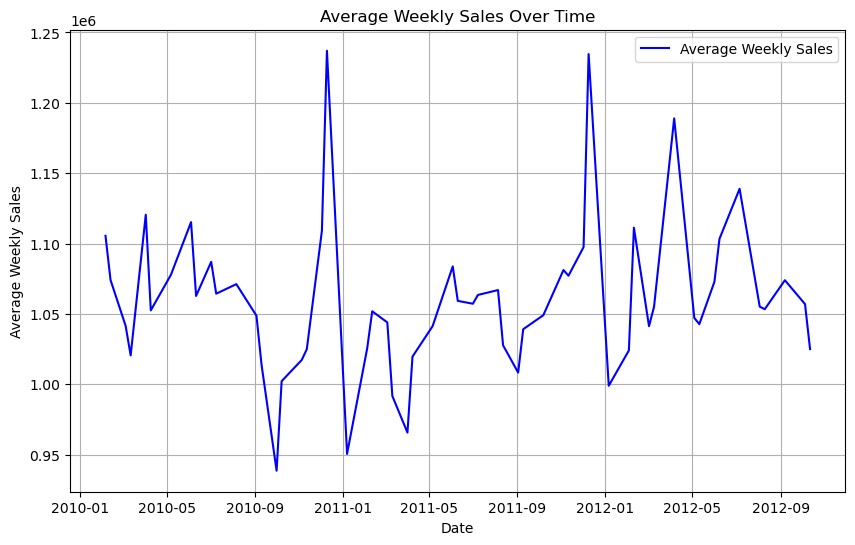

In [43]:
# Group by Date and calculate the average sales
average_sales = df.groupby('Date')['Weekly_Sales'].mean()

# Plot the average weekly sales over time
plt.figure(figsize=(10,6))
plt.plot(average_sales.index, average_sales.values, label='Average Weekly Sales', color='blue')
plt.title('Average Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Average Weekly Sales')
plt.grid(True)
plt.legend()
plt.show()





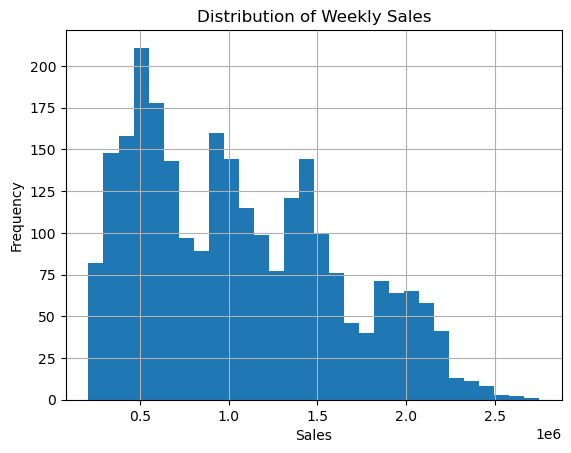

In [75]:
df['Weekly_Sales'].hist(bins=30)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()


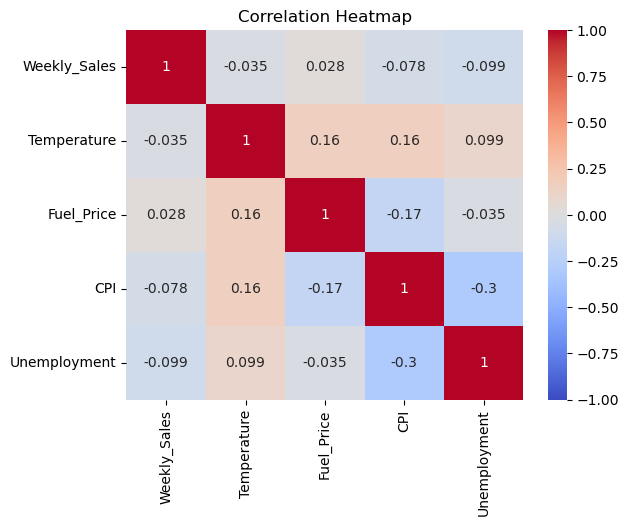

In [77]:
import seaborn as sns

# Calculate correlations between numeric variables
corr = df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()

# Plot the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


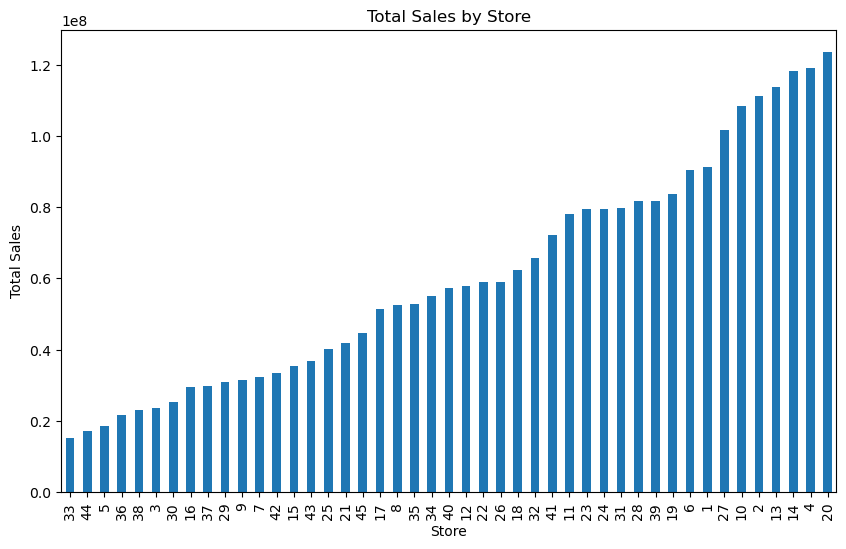

In [81]:
sales_by_store = df.groupby('Store')['Weekly_Sales'].sum().sort_values()
sales_by_store.plot(kind='bar', figsize=(10,6))
plt.title('Total Sales by Store')
plt.ylabel('Total Sales')
plt.show()



In [83]:
# Creating lagged features for weekly sales
df['Sales_lag_1'] = df['Weekly_Sales'].shift(1)  # Previous week's sales
df['Sales_lag_2'] = df['Weekly_Sales'].shift(2)  # Sales two weeks ago
df['Sales_lag_3'] = df['Weekly_Sales'].shift(3)  # Sales three weeks ago

# Drop rows with NaN values caused by shifting
df = df.dropna()



In [93]:
# Define features (including lagged sales) and target (Weekly_Sales)
X = df[['Year', 'Month', 'Week', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
        'Sales_lag_1', 'Sales_lag_2', 'Sales_lag_3']]
y = df['Weekly_Sales']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [95]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train the final XGBoost model with tuned parameters
xgb_model = XGBRegressor(learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'Final Mean Squared Error (XGBoost with Lagged Features): {mse_xgb}')
print(f'Final R-squared (XGBoost with Lagged Features): {r2_xgb}')


Final Mean Squared Error (XGBoost with Lagged Features): 21486965472.121124
Final R-squared (XGBoost with Lagged Features): 0.9329640001478495
